In [1]:
from datamodules import SHMUDataModule
from pathlib import Path
from utils.config import load_config

confpath = Path("") / "configs/LUPIN_differenced"
dsconf = load_config(confpath / "datasets.yaml")
modelconf = load_config(confpath / "model.yaml")

dsconf.SHMUDataset.transform_to_grayscale = True

datamodule = SHMUDataModule(dsconf, modelconf.train_params)
datamodule.setup("test")
dataset = datamodule.test_dataset

test_dataloader = datamodule.test_dataloader()

/opt/anacondas/anaconda3/envs/nowcasting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pysteps configuration file found at: /opt/anacondas/anaconda3/envs/nowcasting/lib/python3.10/site-packages/pysteps/pystepsrc



In [3]:
import torch
from models import MFUNET

model = MFUNET(modelconf).load_from_checkpoint("/data/softec-lagrangian-nowcasting/checkpoints/mfunet-logcosh/epoch=15-step=18864.ckpt", config=modelconf, map_location=torch.device('cuda:0'))

In [4]:
import torch
from models import LUMIN

model = LUMIN(modelconf).load_from_checkpoint("/data/softec-lagrangian-nowcasting/checkpoints/LUMIN-differenced-pretrainedMFUNET/epoch=15-step=50304.ckpt", config=modelconf, map_location=torch.device('cuda:0'))

In [3]:
model.mfunet_network.load_state_dict(model_mf.network.state_dict())

NameError: name 'model_mf' is not defined

In [5]:
x = dataset[36][0]
x = torch.unsqueeze(torch.squeeze(x), dim=0).float().to('cuda:0')

x_diff = dataset[36][1]
x_diff = torch.unsqueeze(torch.squeeze(x_diff), dim=0).float().to('cuda:0')

In [4]:
x_diff = torch.zeros([1, 6, 336, 336]).float().to('cuda:0')

In [10]:
pred, extra, mf = model(x, x_diff)

pred = pred.detach().cpu().numpy()
# mf = mf[0].detach().cpu().numpy()

In [11]:
pred.shape

(1, 1, 336, 336)

In [12]:
x_lagrangian = x.clone()

for i in range(x.shape[1]):
    x_lagrangian[:,i] = model._extrapolate(6-i, x_lagrangian[:,[i]], mf)[:,-1]

x_diff_lagrangian = x_diff.clone()

for i in range(x.shape[1]-1):
    x_diff_lagrangian[:,i] = model._extrapolate(6-i, x_diff_lagrangian[:,[i]], mf)[:,-1]

In [13]:
x_np = dataset.from_grayscale(x[0].detach().cpu().numpy())
x_diff_np = x_diff[0].detach().cpu().numpy()
x_lagrangian_np = dataset.from_grayscale(x_lagrangian[0].detach().cpu().numpy())
x_diff_lagrangian_np = dataset.from_grayscale(x_diff_lagrangian[0].detach().cpu().numpy())

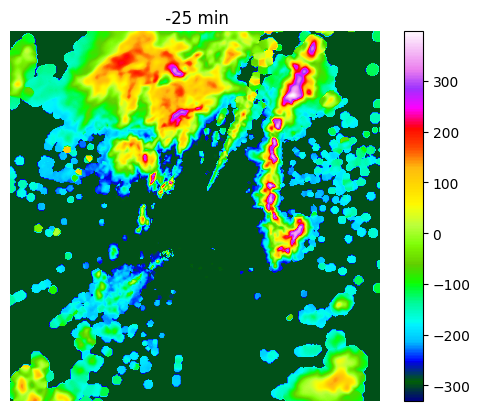

In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML

fig, ax = plt.subplots()

plt.imshow(x_np[0], cmap='gist_ncar')
cbar = plt.colorbar()

def update(frame):
    if frame == 6:
        plt.imshow(pred[0][0], cmap='gist_ncar', vmin=cbar.vmin, vmax=cbar.vmax)
        # plt.title(f"{(frame-5)*5:+4d} min")
    else:
        plt.imshow(x_np[frame], cmap='gist_ncar', vmin=cbar.vmin, vmax=cbar.vmax)
        # plt.title(f"{(frame-5)*5:+4d} min")
    plt.axis('off')
    plt.title(f"{(frame-5)*5:+4d} min")

ani = animate.FuncAnimation(fig=fig, func=update, frames=7)
HTML(ani.to_jshtml())

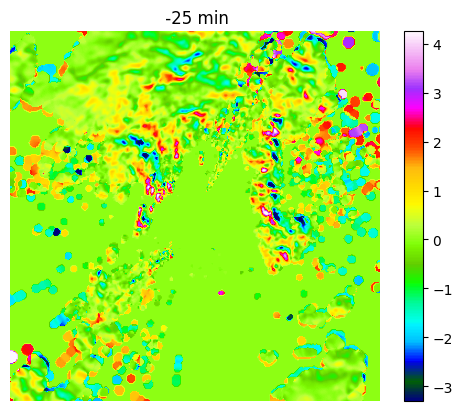

In [16]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML

fig, ax = plt.subplots()

plt.imshow(pred[0][0], cmap='gist_ncar')
cbar = plt.colorbar()

def update(frame):
    if frame == 5:
        plt.imshow(pred[0][0], cmap='gist_ncar', vmin=cbar.vmin, vmax=cbar.vmax)
        # plt.title(f"{(frame-5)*5:+4d} min")
    else:
        plt.imshow(x_diff_np[frame], cmap='gist_ncar', vmin=cbar.vmin, vmax=cbar.vmax)
        # plt.title(f"{(frame-5)*5:+4d} min")
    plt.axis('off')
    plt.title(f"{(frame-5)*5:+4d} min")

ani = animate.FuncAnimation(fig=fig, func=update, frames=6)
HTML(ani.to_jshtml())

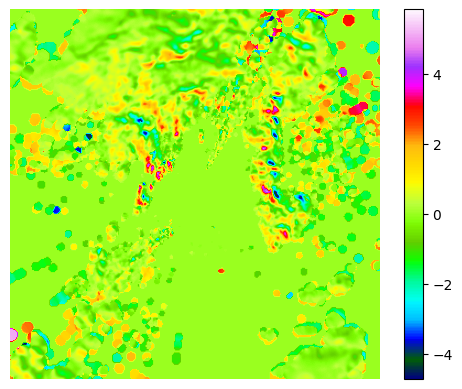

In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML

fig, ax = plt.subplots()

plt.imshow(x_diff_np[0], cmap='gist_ncar')
cbar = plt.colorbar()

def update(frame):
    if frame == 5:
        plt.imshow(pred[0][0], cmap='gist_ncar', vmin=cbar.vmin, vmax=cbar.vmax)
    else:
        plt.imshow(x_diff_np[frame], cmap='gist_ncar', vmin=cbar.vmin, vmax=cbar.vmax)
    plt.axis('off')
    # plt.title(f"{(frame-5)*5:+4d} min")
    # plt.show()

ani = animate.FuncAnimation(fig=fig, func=update, frames=6)
HTML(ani.to_jshtml())

<Axes: >

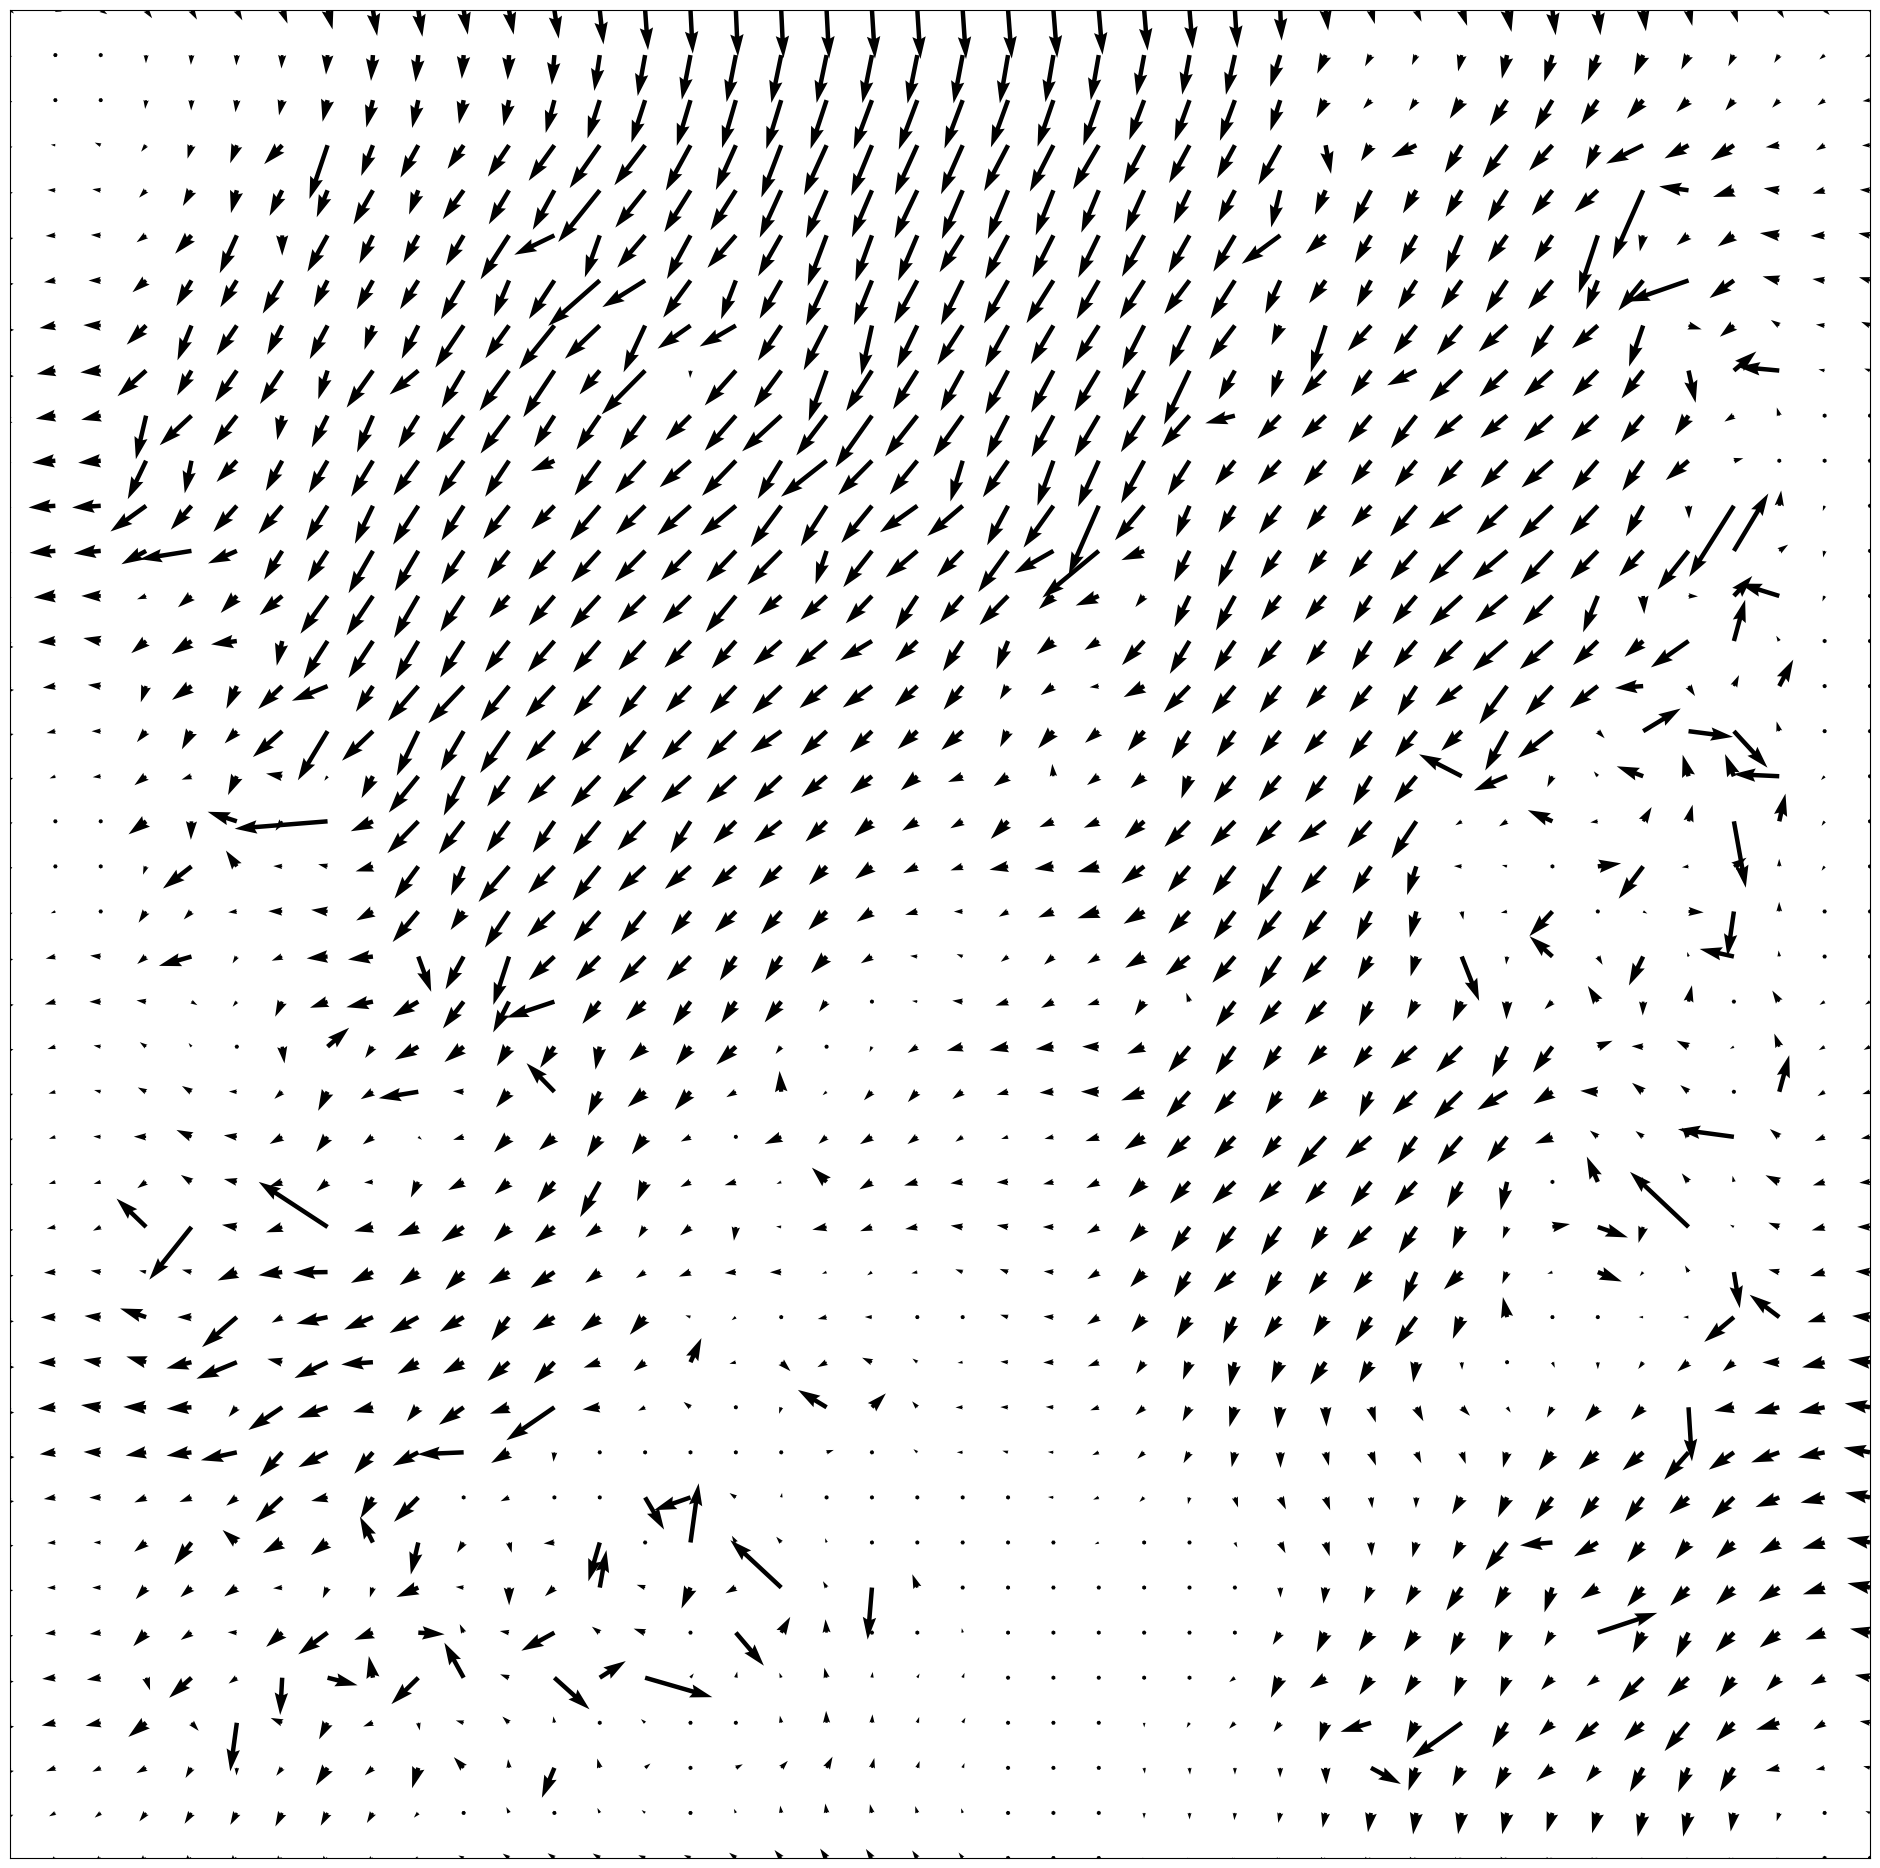

In [15]:
from pysteps.visualization import plot_precip_field, quiver
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(24, 24))
# plt.imshow(x_np[-1], cmap='gist_ncar')
#plot_precip_field(pred, ax=ax, axis="off", units="dBZ")

mf_np = mf[0].detach().cpu().numpy()
#mf_np[mf_np > 0.1] = 0.1
#mf_np[mf_np < -0.1] = -0.1
# mf_np[1] *= -1

# Plot the motion field vectors
quiver(mf_np, step=8)

<Axes: >

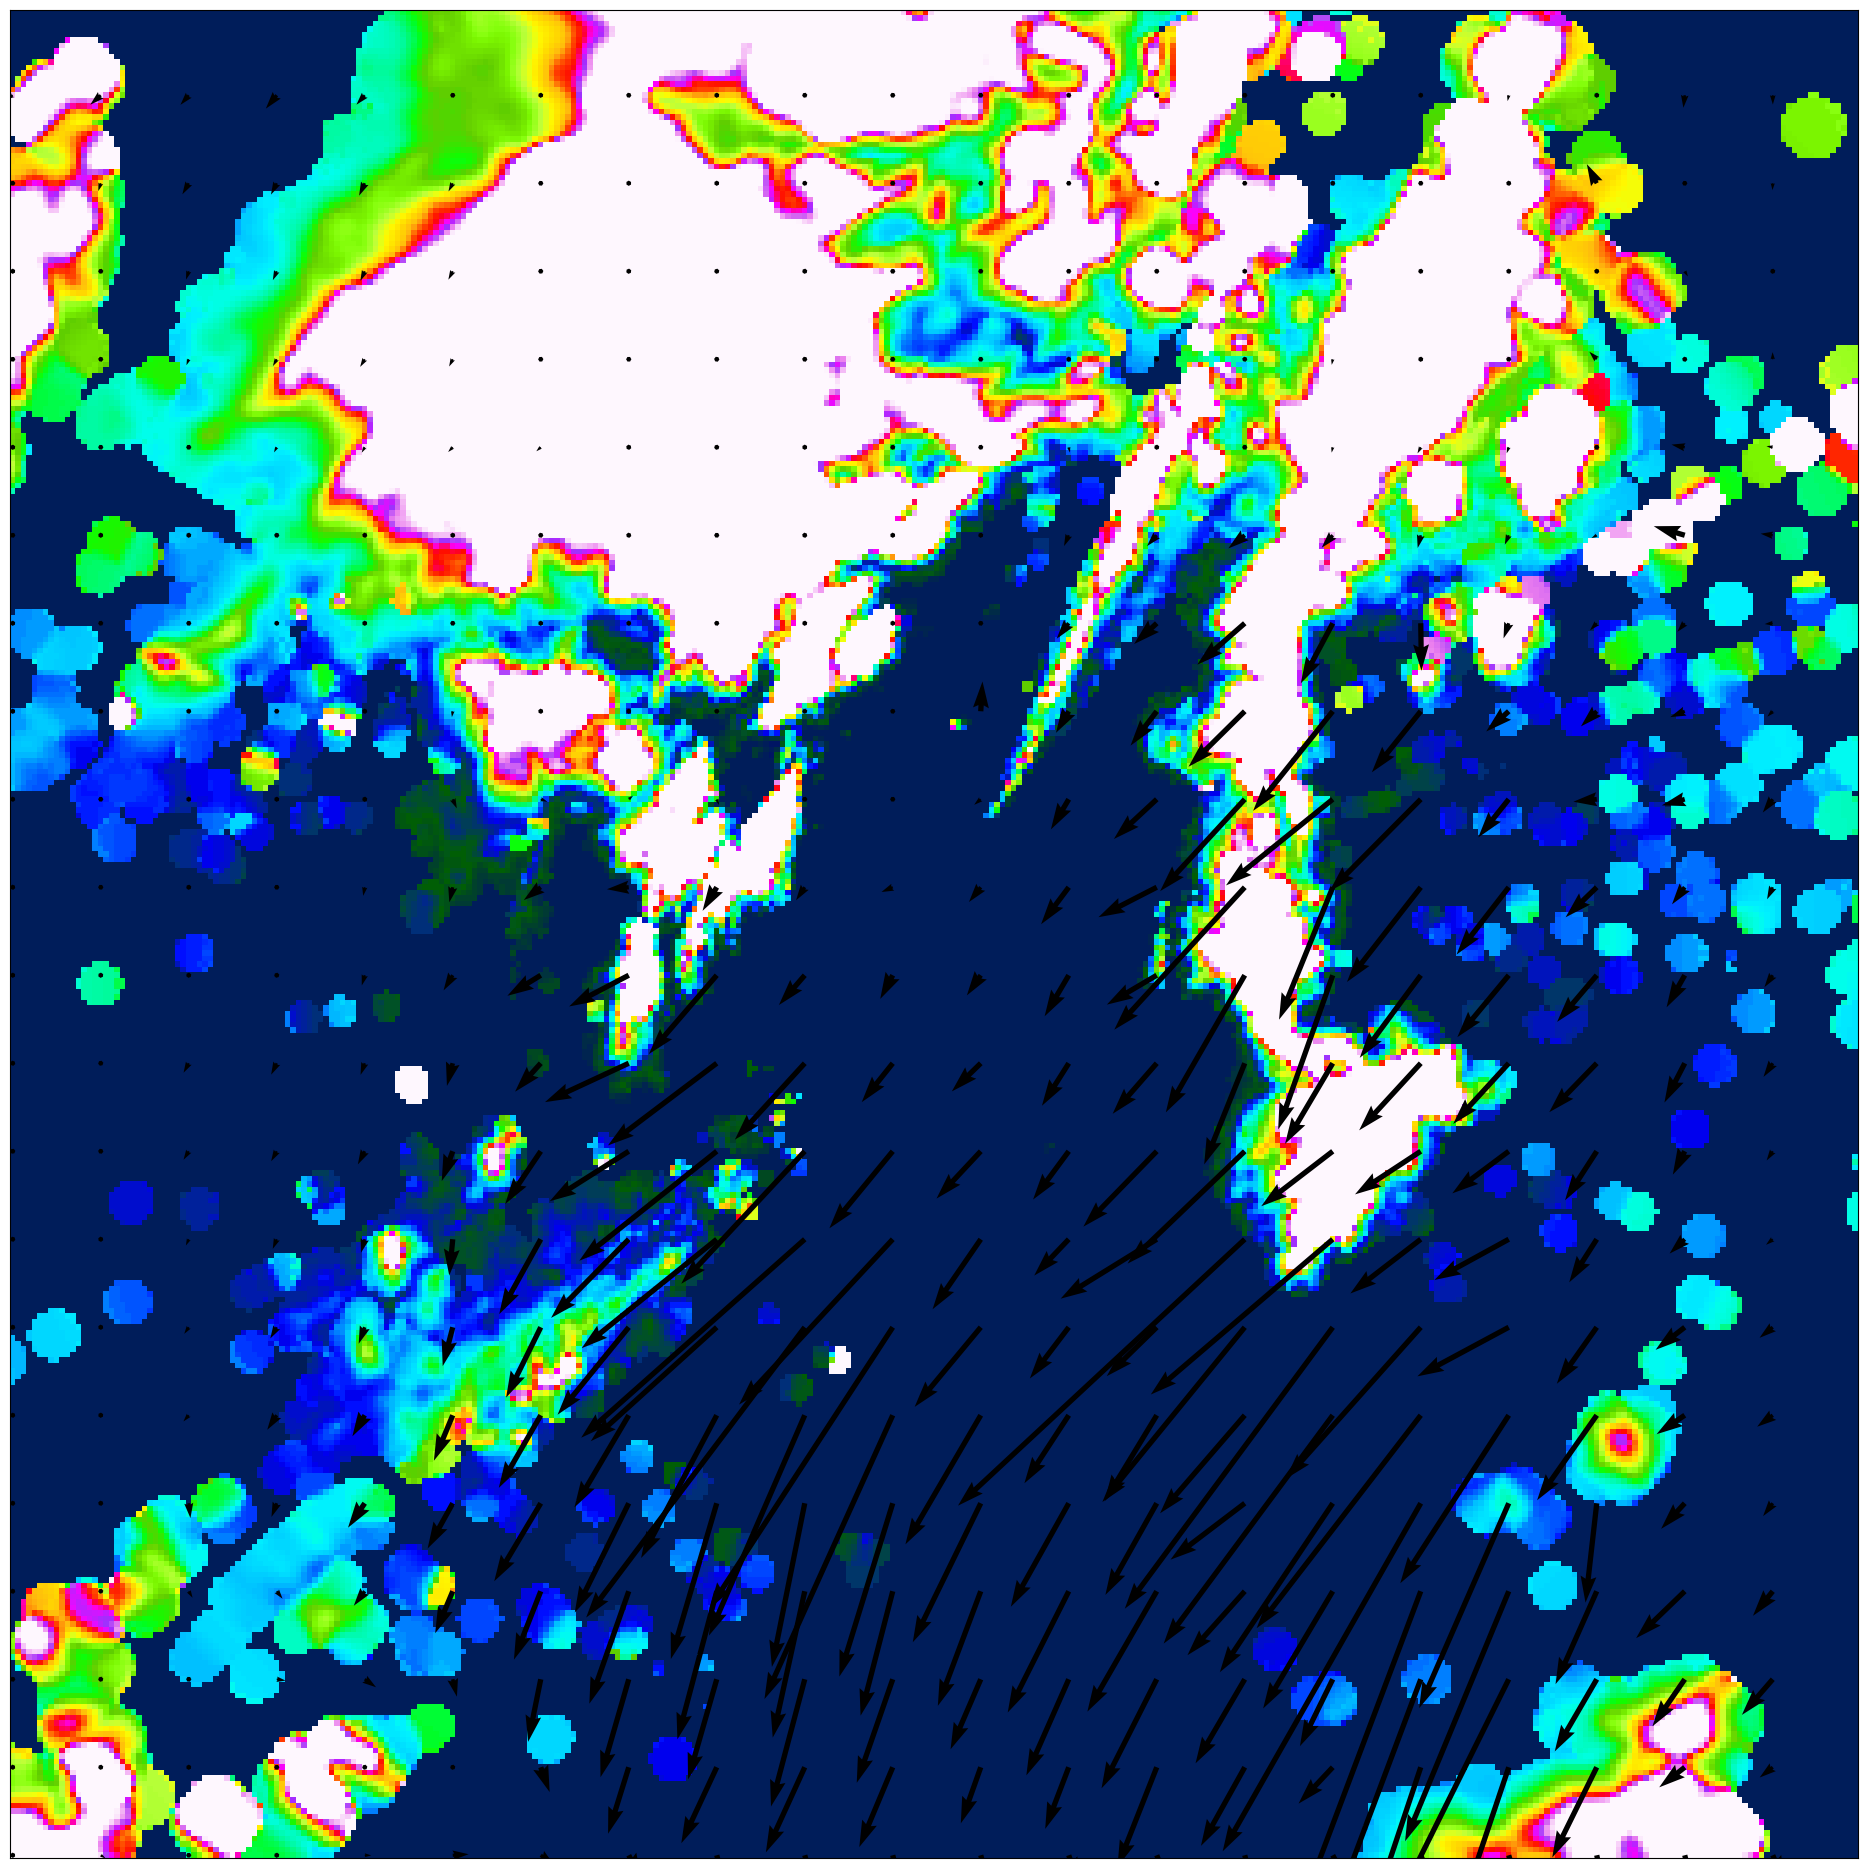

In [37]:
from pysteps.visualization import plot_precip_field, quiver
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(24, 24))
plt.imshow(x_np[-1], cmap='gist_ncar', vmin=-16, vmax=70)
#plot_precip_field(pred, ax=ax, axis="off", units="dBZ")

mf_np = mf[0].detach().cpu().numpy()
#mf_np[mf_np > 0.1] = 0.1
#mf_np[mf_np < -0.1] = -0.1
mf_np[1] *= -1

# Plot the motion field vectors
quiver(mf_np, step=16)

In [33]:
max(mf_np.flatten())

9.6936035